KR vs DH binary classifier
Script overview: 
1. Block 1 of the script imports KS domains from files in "route" and combines with substrate labels generated from file "labels_sheet", then balances the dataset based on the minimal category 
2. Block 2 generates graph networks from carbon alphas using a k-nearest neighbour method. Features are supplied as a OHE of amino acid type. Labels are unified in the graph constructor as graph_y.
3. Block 3 is a dataloader. KS substrate type is balanced in this block for Train, Validation and Test data.
4. Block 4 contains the GNN model, training loop and test step.
5. Block 5  loop that explains each graph in the test data partition.

In [5]:
#### Block 1 ####
### Import pdb files and labels -> prepare for graph creation ###
import os
import torch
import graphein
import pandas as pd
import re

## Import pdb files ##
route = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20240911_KS_dimers_extras_aligned_reviewed/"

# List of filenames in the pdb folder "route" #
filenames = os.listdir(route)

# Create a list of absolute file paths in route # 
absolute_file_paths = [os.path.join(route, filename) for filename in filenames]

## Import labels from file and create a dataframe matched to pdb files ##
label_sheet = pd.read_csv("/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/20250624_KS_expandedset_reduction_state_labels_new_borders_KR_types.csv")   # expanded set adds 23 more clusters

# Extract gene names from file names
gene_names = [re.match(r'(.+)\.', os.path.splitext(os.path.basename(path))[0]).group(1) for path in absolute_file_paths]

# Filter labels for the matched gene names
matched_labels = label_sheet[label_sheet.iloc[:, 0].isin(gene_names)].set_index(label_sheet.columns[0])

# Create a list of gene names from the absolute file paths
file_path_gene_names = [re.match(r'(.+)\.', os.path.splitext(os.path.basename(path))[0]).group(1) for path in absolute_file_paths]

# Reorder matched_labels to match the order of absolute_file_paths
reordered_labels = matched_labels.loc[file_path_gene_names]

# Add paths # 
reordered_labels["paths"] = absolute_file_paths

NR_total = sum(reordered_labels['NR'])
print("NR:", NR_total) 
DH_total = sum(reordered_labels['DH'])
print("DH:", DH_total) 
ER_total = sum(reordered_labels['ER'])
print("ER:", ER_total) 
KRa_total = sum(reordered_labels['KRa'])
print("KRa:", KRa_total) 
KRb_total = sum(reordered_labels['KRb'])
print("KRb:", KRb_total) 
total_states = NR_total + KRa_total + KRb_total + DH_total + ER_total
num_genes = len(reordered_labels)
print("Total reduction states:", total_states)
print("Number of genes:", num_genes)

# Divide labels
categories_list = ['KRb','NR']
minimum_category = min( KRa_total, NR_total)
sample_size = minimum_category # You can set this to your desired sample size

padded_categories = []

for category in categories_list:
    category_rows = reordered_labels[reordered_labels[category] == 1]
    num_samples = min(sample_size, len(category_rows))
    category_rows = category_rows.sample(n=num_samples)
    if num_samples < sample_size:
        additional_samples = category_rows.sample(n=sample_size - num_samples, replace=True)
        category_rows = pd.concat([category_rows, additional_samples])
    
    padded_categories.append(category_rows)

# Concatenate the original data with the padded categories
balanced_reordered_labels = pd.concat(padded_categories)

# Reset the index to ensure it's unique
balanced_reordered_labels.reset_index(drop=True, inplace=True)

# Print the counts for each category after balancing
for category in categories_list:
    category_count = len(balanced_reordered_labels[balanced_reordered_labels[category] == 1])
    print(f"Balanced {category}: {category_count}")

balanced_reordered_labels2 = balanced_reordered_labels.drop('paths', axis=1)
balanced_reordered_labels2 = balanced_reordered_labels2.drop('DH', axis=1)
balanced_reordered_labels2 = balanced_reordered_labels2.drop('ER', axis=1)
balanced_reordered_labels2 = balanced_reordered_labels2.drop('KRa', axis=1)

graph_label_map = balanced_reordered_labels2.to_dict(orient='index')
print(graph_label_map)

NR: 121
DH: 383
ER: 165
KRa: 161
KRb: 159
Total reduction states: 989
Number of genes: 1192
Balanced KRb: 124
Balanced NR: 123
{0: {'NR': 0, 'KRb': 1}, 1: {'NR': 0, 'KRb': 1}, 2: {'NR': 0, 'KRb': 1}, 3: {'NR': 0, 'KRb': 1}, 4: {'NR': 0, 'KRb': 1}, 5: {'NR': 0, 'KRb': 1}, 6: {'NR': 0, 'KRb': 1}, 7: {'NR': 0, 'KRb': 1}, 8: {'NR': 0, 'KRb': 1}, 9: {'NR': 0, 'KRb': 1}, 10: {'NR': 0, 'KRb': 1}, 11: {'NR': 0, 'KRb': 1}, 12: {'NR': 0, 'KRb': 1}, 13: {'NR': 0, 'KRb': 1}, 14: {'NR': 0, 'KRb': 1}, 15: {'NR': 0, 'KRb': 1}, 16: {'NR': 0, 'KRb': 1}, 17: {'NR': 0, 'KRb': 1}, 18: {'NR': 0, 'KRb': 1}, 19: {'NR': 0, 'KRb': 1}, 20: {'NR': 0, 'KRb': 1}, 21: {'NR': 0, 'KRb': 1}, 22: {'NR': 0, 'KRb': 1}, 23: {'NR': 0, 'KRb': 1}, 24: {'NR': 0, 'KRb': 1}, 25: {'NR': 0, 'KRb': 1}, 26: {'NR': 0, 'KRb': 1}, 27: {'NR': 0, 'KRb': 1}, 28: {'NR': 0, 'KRb': 1}, 29: {'NR': 0, 'KRb': 1}, 30: {'NR': 0, 'KRb': 1}, 31: {'NR': 0, 'KRb': 1}, 32: {'NR': 0, 'KRb': 1}, 33: {'NR': 0, 'KRb': 1}, 34: {'NR': 0, 'KRb': 1}, 35: {'N

Output()

/home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py:160: FutureWarning:

The default value of regex will change from True to False in a future version.

/home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py:163: FutureWarning:

The default value of regex will change from True to False in a future version.

[09/08/25 11:54:43] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=180107;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=25122;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py#186\186]8;;\

                    DEBUG    Detected 826 total nodes                                                 ]8;id=328318;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=200953;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/graphs.py#438\438]8;;\

                    INFO     Found: 3304 KNN edges                                                 ]8;id=191151;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=132147;file:///home/q31032mw/miniconda3/lib/python3.8/site-packages/graphein/protein/edges/distance.py#1130\1130]8;;\

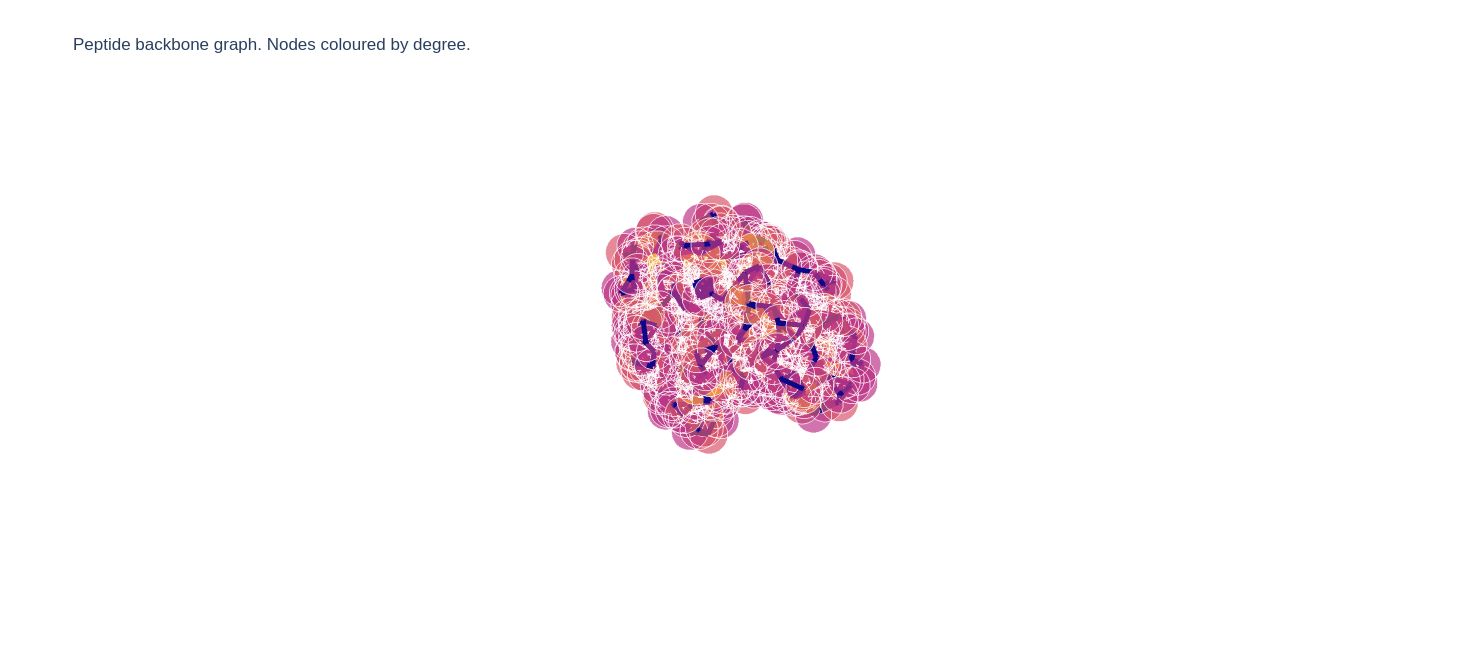

done
ProteinGraphDataset(242)
242


In [6]:
#### Block 2 #### 
### Graph Creation methods: ###
## K nearest neighbours ##
from functools import partial
from graphein.protein.edges.distance import add_k_nn_edges
from graphein.protein.features.nodes.amino_acid import amino_acid_one_hot
from graphein.protein.visualisation import plotly_protein_structure_graph
from graphein.protein.graphs import construct_graph

new_edge_funcs = {"edge_construction_functions": [partial(add_k_nn_edges, k=4, long_interaction_threshold=0)],
                  "node_metadata_functions": [amino_acid_one_hot]
                  }
config = graphein.protein.ProteinGraphConfig(**new_edge_funcs)

g = construct_graph(config=config, path=absolute_file_paths[0])

p = plotly_protein_structure_graph(
    g,
    colour_edges_by="kind",
    colour_nodes_by="degree",
    label_node_ids=False,
    plot_title="Peptide backbone graph. Nodes coloured by degree.",
    node_size_multiplier=1
    )
p.show()

### Create an in-file dataset for passing to pytorch geometric ###
## Note: this can take a while. If the dataset already exists it won't be regenerated ##
from graphein.ml import GraphFormatConvertor, ProteinGraphDataset

# list of columns included in nx ==> pyg conversion #
info_list = ["edge_index", 
             "amino_acid_one_hot",
             "node_id", 
             "chain_id", 
             "residue_name", 
             "residue_number", 
             "atom_type", 
             "element_symbol",
             "coords",
             "b_factor", 
             "kind", 
             "name",
             "chain_ids"]

# NetworkX to PyG conversion #
convertor= GraphFormatConvertor(src_format = "nx", 
                                dst_format = "pyg", 
                                verbose = "all_info", 
                                columns = info_list
                               )

# Convert the graph_label_map dictionary to a list of tensors # 
graph_labels_list = [torch.tensor(list(label.values())) for label in graph_label_map.values()]

# Convert paths to a list of paths
paths_list=balanced_reordered_labels['paths'].tolist()
# Create the dataset with graph_labels as a list of tensors #
dataset = ProteinGraphDataset(
    root='/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/Rank_1/120250622_KS_dimers_Reduction_State_K4_KRb_NR', 
    paths=paths_list,
    graphein_config=config, 
    graph_labels=graph_labels_list,
    graph_format_convertor=convertor,
    num_cores=7
)

print("done")

print(dataset)
print(len(graph_labels_list))

In [7]:
#### Block 3 #### 
### Data loader ### 
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_add_pool
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Split the dataset into training, validation, and test sets #
train_ratio = 0.8
val_ratio = 0.19
test_ratio = 0.01
batch_size = 64

# Define your custom Data class with __cat_dim__ method
class MyData(Data):
    def __cat_dim__(self, key, value, *args, **kwargs):
        if key == 'graph_y':
            return None  # Indicates that 'graph_y' should be batched along a new dimension
        return super().__cat_dim__(key, value, *args, **kwargs)

# Create a list of Data objects, ensuring 'graph_y' is a 2D tensor [num_examples, num_labels]
# Initialize an empty list to store the modified Data objects
data_list = []

# Iterate through your existing ProteinGraphDataset
for graph in dataset:
    # Create a new Data object
    data = Data(
        edge_index = graph.edge_index, 
        node_id = graph.node_id,
        coords = graph.coords, 
        name = graph.name,
        num_nodes = graph.num_nodes,
        graph_y = graph.graph_y.view(1, 2), 
        x=graph.amino_acid_one_hot.view(len(graph.node_id), 20),
    )
    # Append the modified Data object to the list
    data_list.append(data)




# Extract labels from your data_list
labels = [data.graph_y.tolist()[0] for data in data_list]

# Split the data into training, validation, and test sets with stratified sampling
train_data, test_data, train_labels, test_labels = train_test_split(data_list, labels, test_size=test_ratio, random_state=42, stratify=labels)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=val_ratio/(1-test_ratio), random_state=42, stratify=train_labels)

# Create DataLoader for training, validation, and test sets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

print("Train_set:", len(train_loader.dataset))
print("Val_set:", len(val_loader.dataset))
print("Test_set:", len(test_loader.dataset))

def count_labels(loader):
    KRa_count = 0
    NR_count = 0
    total_count = 0
    
    for batch in loader:
        # Extract labels from the batch
        labels = batch.graph_y.squeeze().tolist()
        
        # Count mal and mmal labels in the batch
        KRa_count += labels.count([0, 1])
        NR_count += labels.count([1, 0])
        total_count += len(labels)
    
    return KRa_count, NR_count, total_count

# Calculate label composition for each loader
train_KRa, train_NR, train_total = count_labels(train_loader)
val_KRa, val_NR,  val_total = count_labels(val_loader)
test_KRa, test_NR, test_total = count_labels(test_loader)

# Print the results
print("Training Set Composition:")
print(f"KRa: {train_KRa} samples, NR: {train_NR} samples, Total: {train_total} samples")


print("\nValidation Set Composition:")
print(f"KRa: {val_KRa} samples, NR: {val_NR}, Total: {val_total} samples")


print("\nTest Set Composition:")
print(f"KRa: {test_KRa} samples, NR: {test_NR}, Total: {test_total} samples")


Train_set: 193
Val_set: 46
Test_set: 3
Training Set Composition:
KRa: 93 samples, NR: 95 samples, Total: 194 samples

Validation Set Composition:
KRa: 23 samples, NR: 22, Total: 46 samples

Test Set Composition:
KRa: 2 samples, NR: 1, Total: 3 samples


DataBatch(x=[54112, 20], edge_index=[2, 124218], node_id=[64], coords=[54112, 3], name=[64], num_nodes=54112, graph_y=[64, 2], batch=[54112], ptr=[65])
Epoch [1/250] - Train Loss: 0.6958 - Train Accuracy: 0.4508 - Train AUC: 0.3502 - Validation Loss: 0.6934 - Validation Accuracy: 0.5000 - Validation AUC: 0.4915
Epoch [2/250] - Train Loss: 0.6929 - Train Accuracy: 0.5130 - Train AUC: 0.3958 - Validation Loss: 0.6932 - Validation Accuracy: 0.5000 - Validation AUC: 0.5293
Epoch [3/250] - Train Loss: 0.6925 - Train Accuracy: 0.5130 - Train AUC: 0.4730 - Validation Loss: 0.6931 - Validation Accuracy: 0.5000 - Validation AUC: 0.5539
Epoch [4/250] - Train Loss: 0.6925 - Train Accuracy: 0.5130 - Train AUC: 0.4838 - Validation Loss: 0.6932 - Validation Accuracy: 0.5000 - Validation AUC: 0.5917
Epoch [5/250] - Train Loss: 0.6923 - Train Accuracy: 0.5130 - Train AUC: 0.5316 - Validation Loss: 0.6934 - Validation Accuracy: 0.5000 - Validation AUC: 0.6125
Epoch [6/250] - Train Loss: 0.6920 - Train 

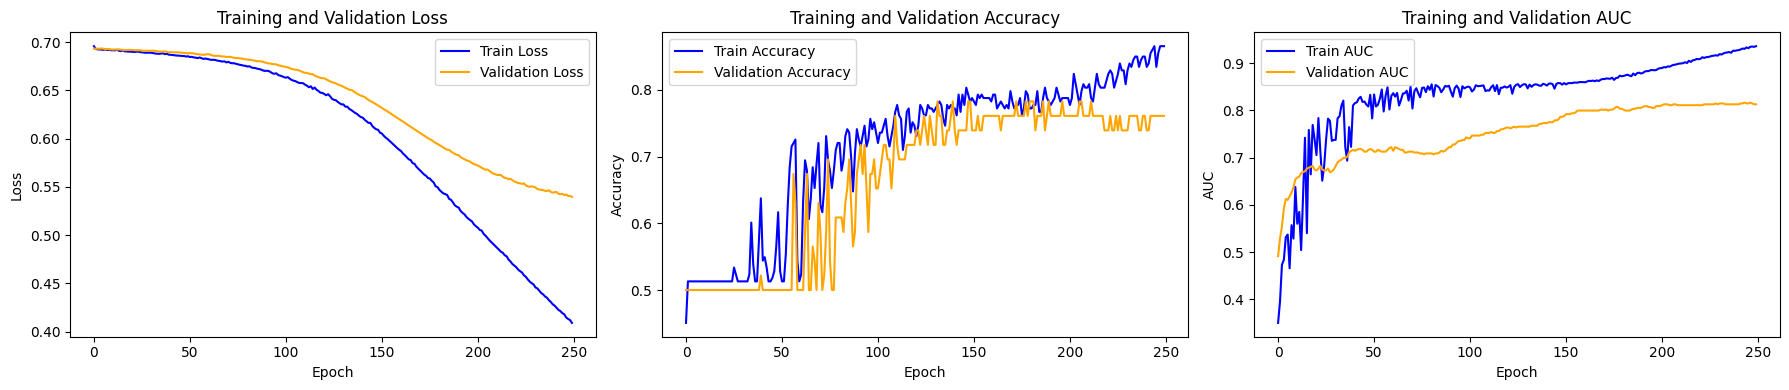

Training finished!
Test Accuracy: 1.0000
Test AUC: 1.0000
Training metrics saved to 'KRb vs NR metrics/KRb_vs_NR_2025-09-08_11-58.csv'


In [8]:
#### Block 4 #### 
### Training and validation ###
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_max_pool
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Set seed
torch.manual_seed(15706112877486103401)

# Network parameters
input_dim = 20  # Corresponds to amino acid OHE
hidden_dim = 64 # Neural network density
output_dim = 2  # Set model to binary classification

# Hyperparameters
num_epochs = 250
learning_rate = 0.001

# Define a GNN model
# Define a GNN model
class MyGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MyGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        # Convert input tensor 'x' to Float data type
        x = x.float()
        
        # Apply the first graph convolution layer
        x = self.conv1(x, edge_index)
        x = x.relu()
    
        # Apply the second graph convolution layer
        x = self.conv2(x, edge_index)
        x = x.sigmoid()
    
        # Perform graph-level pooling (e.g., global max pooling)
        x = global_max_pool(x, batch)
        x = self.lin(x)
        #x = torch.relu(x)  # Sigmoid activation for binary classification
    
        return x

# Initialize your GNN model
model = MyGNN(input_dim, hidden_dim, output_dim)

# Define batching
batch = next(iter(train_loader))
print(batch)

# Forward pass through the model
out = model(batch.x, batch.edge_index, batch.batch)

# Define optimization method
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Empty containers for loss and accuracy metrics
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

train_aucs = []  # New list to store training AUC values
val_aucs = []  # New list to store validation AUC values

## Training and validation loops ##
for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    total_correct_train = 0
    total_samples_train = 0
    train_predictions = []  # New list to store training predictions
    train_labels_all = []  # New list to store true training labels
    
    # Training loop
    model.train()
    train_correct_count = 0  # Total number of correct predictions for the epoch
    train_total_count = 0  # Total number of samples for the epoch

    # Validation loop
    model.eval()
    val_loss = 0.0
    total_correct_val = 0
    total_samples_val = 0
    val_predictions = []  # New list to store predictions
    val_labels_all = []  # New list to store true labels
    
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
    
            labels = (batch.graph_y[:, 0] == 1).long()
    
            loss = F.cross_entropy(out, labels, reduction='sum')
            val_loss += loss.item()
    
            predicted_labels = out.argmax(dim=1)
            total_correct_val += (predicted_labels == labels).sum().item()
            total_samples_val += labels.size(0)
    
            # Store predictions and true labels for each batch
            val_predictions.extend(out[:, 1].cpu().numpy())  # Detach not needed for no_grad context
            val_labels_all.extend(labels.cpu().numpy())


    
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Convert graph_y to binary labels
        labels = (batch.graph_y[:, 0] == 1).long()
        
        # Compute loss
        loss = F.cross_entropy(out, labels, reduction='sum')
        epoch_train_loss += loss.item()
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        predicted_labels = out.argmax(dim=1)
        train_correct_count += (predicted_labels == labels).sum().item()
        train_total_count += labels.size(0)
        
        # Store predictions and true labels for each batch
        train_predictions.extend(out[:, 1].detach().cpu().numpy())  # Detach the tensor before converting to numpy
        train_labels_all.extend(labels.detach().cpu().numpy())
    
    avg_train_loss = epoch_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    
    # Calculate training accuracy
    train_accuracy = train_correct_count / train_total_count
    train_accuracies.append(train_accuracy)
    
    # Calculate AUC-ROC for training data
    train_auc = roc_auc_score(train_labels_all, train_predictions)
    train_aucs.append(train_auc)
    
    
    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    
    # Calculate overall validation accuracy using all true labels
    val_accuracy = total_correct_val / total_samples_val
    val_accuracies.append(val_accuracy)
    
    # Calculate AUC-ROC for validation data
    val_auc = roc_auc_score(val_labels_all, val_predictions)
    val_aucs.append(val_auc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Train Accuracy: {train_accuracy:.4f} - Train AUC: {train_auc:.4f} - Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f} - Validation AUC: {val_auc:.4f}")

# Plotting the training progress
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_aucs, label='Train AUC', color='blue')
plt.plot(val_aucs, label='Validation AUC', color='orange')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training and Validation AUC')
plt.legend()

plt.tight_layout()
plt.show()

print("Training finished!")

### Test data ###
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score

# Assuming you have your test data in a DataLoader called test_loader
# If you don't have one, create it similarly to how you created train_loader and val_loader.

# Set the model to evaluation mode
model.eval()

# Initialize variables for accuracy calculation
total_correct_test = 0
total_samples_test = 0

# Lists to store predictions and true labels for potential further analysis
test_predictions = []
test_labels = []
test_probabilities = []  # New list to store probabilities for AUC

# Iterate through the test DataLoader
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)  # Send data to GPU if available
        out = model(batch.x, batch.edge_index, batch.batch)
        
        # Convert graph_y to binary labels
        labels = (batch.graph_y[:, 0] == 1).long()
        
        # Calculate predictions
        predicted_labels = out.argmax(dim=1)
        
        # Accumulate the number of correct predictions and total samples
        total_correct_test += (predicted_labels == labels).sum().item()
        total_samples_test += labels.size(0)

        # Store predictions and true labels
        test_predictions.extend(predicted_labels.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probabilities.extend(out[:, 1].cpu().numpy())  # Store the probabilities for the positive class

# Calculate test accuracy
test_accuracy = accuracy_score(test_labels, test_predictions)

# Calculate test AUC
test_auc = roc_auc_score(test_labels, test_probabilities)

# Report the test accuracy and AUC
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

import pandas as pd
import os
from datetime import datetime

# Create the metrics DataFrame
metrics_df = pd.DataFrame({
    'Epoch': list(range(1, num_epochs + 1)),
    'Train_Loss': train_losses,
    'Validation_Loss': val_losses,
    'Train_Accuracy': train_accuracies,
    'Validation_Accuracy': val_accuracies,
    'Train_AUC': train_aucs,
    'Validation_AUC': val_aucs
})

# Set your folder destination
output_folder = 'KRb vs NR metrics'  # Customize if needed

# Create the folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Generate timestamp without seconds
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
filename = f"KRb_vs_NR_{timestamp}.csv"

# Full path to the output file
filepath = os.path.join(output_folder, filename)

# Save the DataFrame to CSV
metrics_df.to_csv(filepath, index=False)

print(f"Training metrics saved to '{filepath}'")

In [12]:
import torch
torch.save(model.state_dict(), '20250908_KRbvsNR_e250.pth')
print("Model saved successfully!")

Model saved successfully!


In [13]:
# Initialize the model structure
model = MyGNN(input_dim, hidden_dim, output_dim)

# Load the saved model parameters
model.load_state_dict(torch.load('20240912_KRvsDH_150epoch.pth'))

# Make sure the model is in evaluation mode if you're using it for inference
model.eval()


MyGNN(
  (conv1): GCNConv(20, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

Processing batch with 46 graphs
Explanation for graph slnA3_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


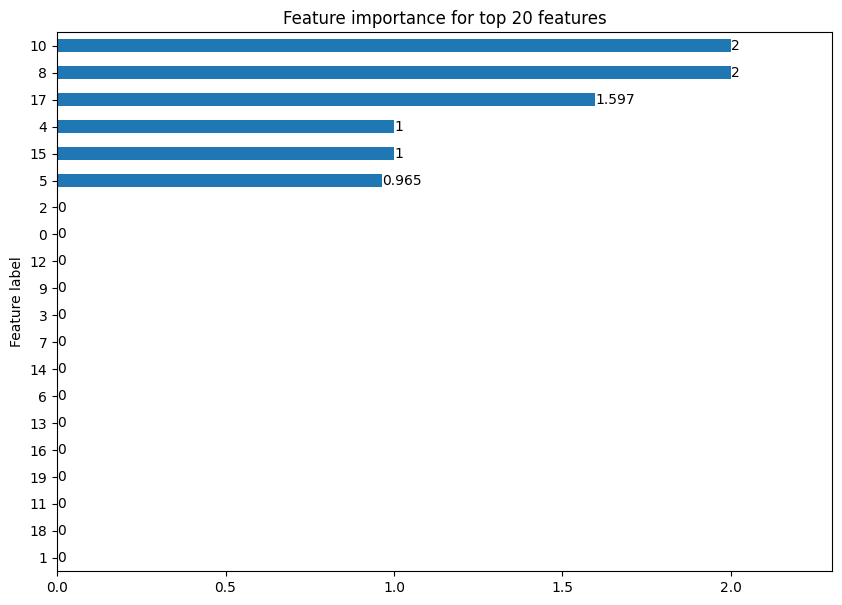

Explanation for graph idmL_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[6.9657e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


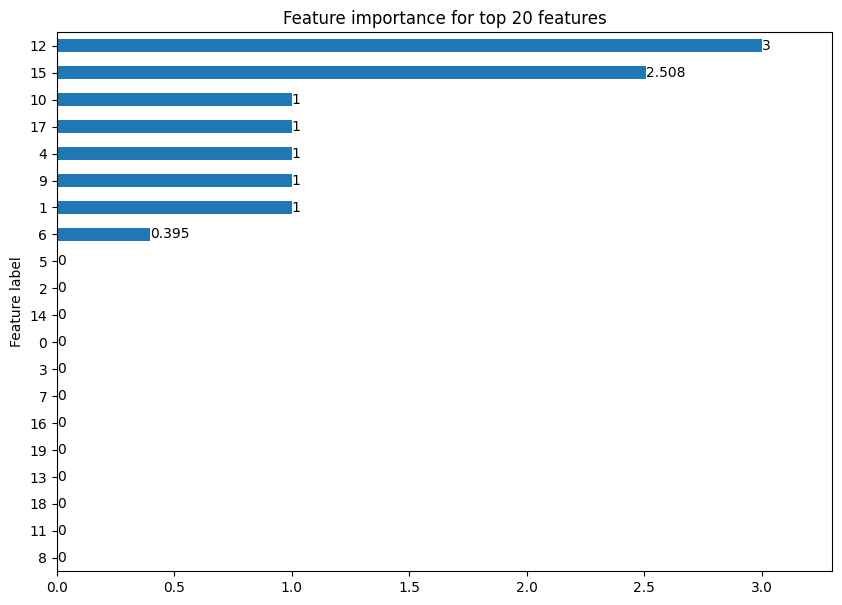

Explanation for graph borA3_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.3786e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


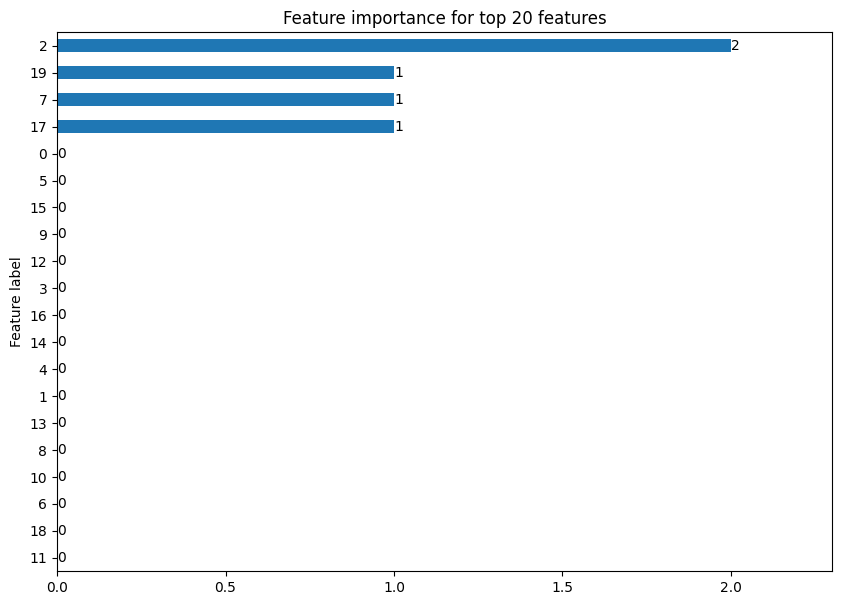

Explanation for graph becF_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.2530e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


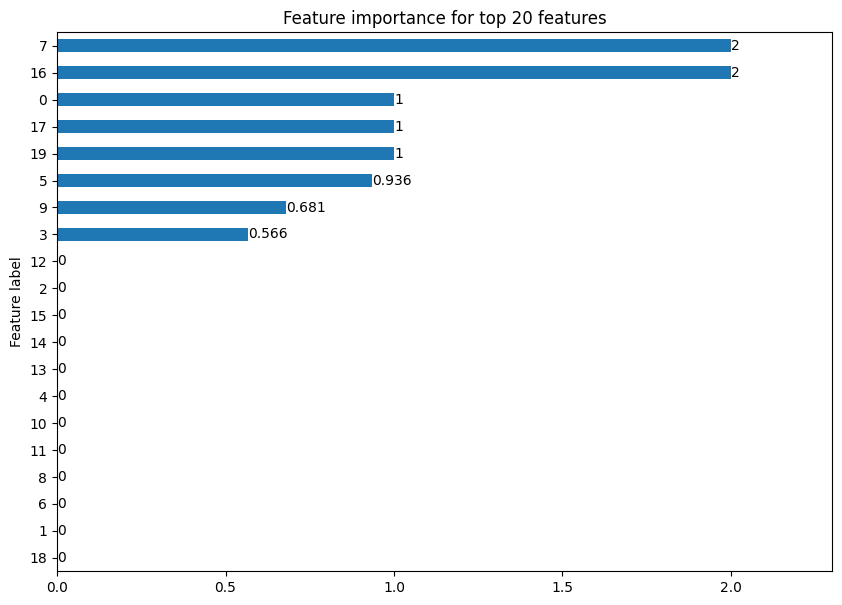

Explanation for graph ttmJ_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


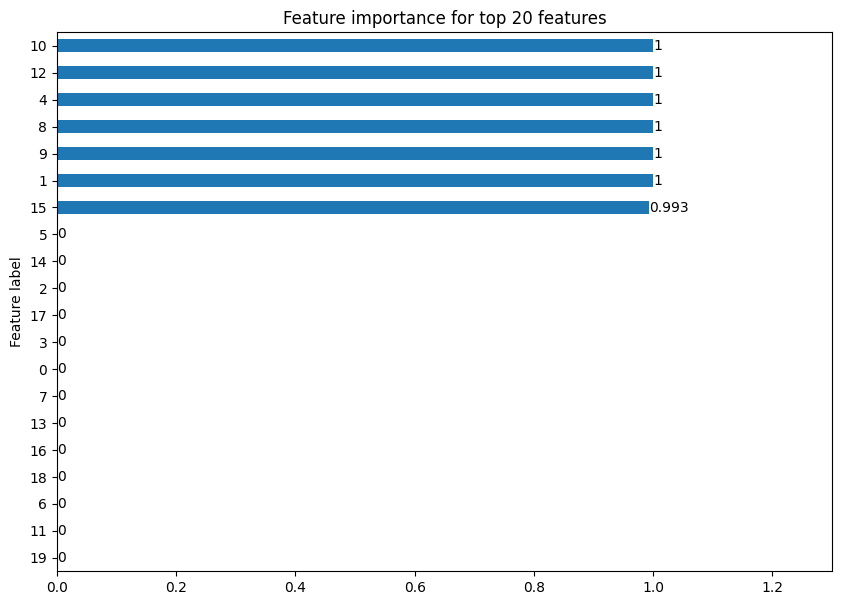

Explanation for graph azlG_Mod.15.pdb_aligned: tensor([7.4752e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


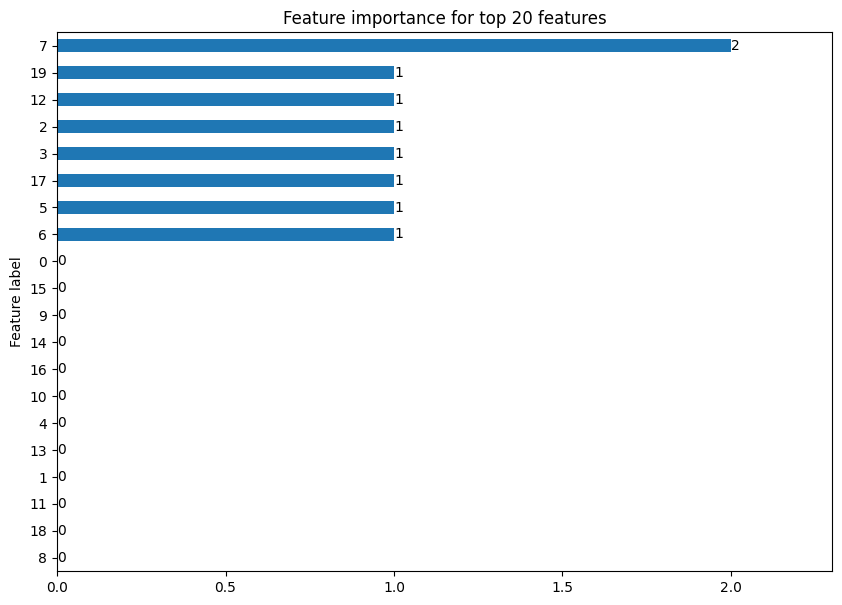

Explanation for graph fscB_Mod.2.pdb_aligned: tensor([0.0000e+00, 0.0000e+00, 6.2671e-11,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


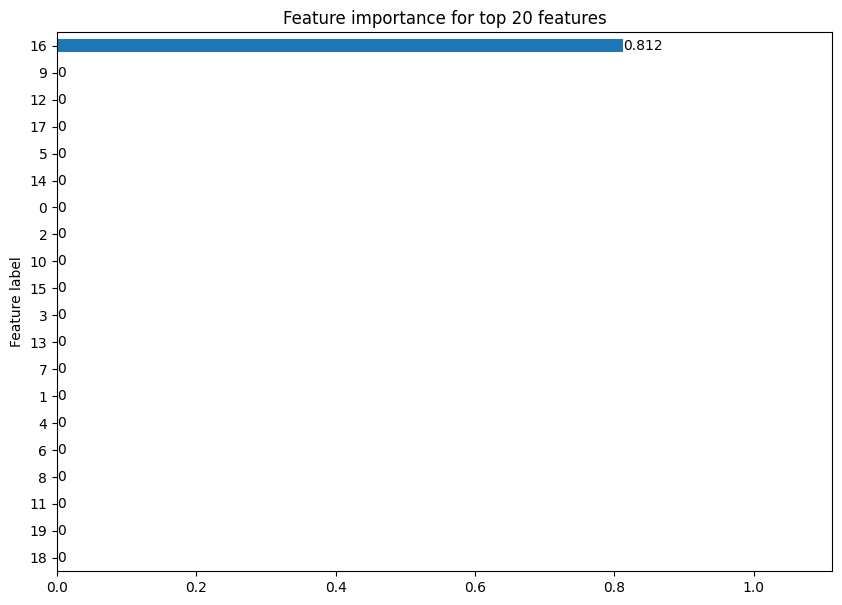

Explanation for graph plm5_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.2170e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


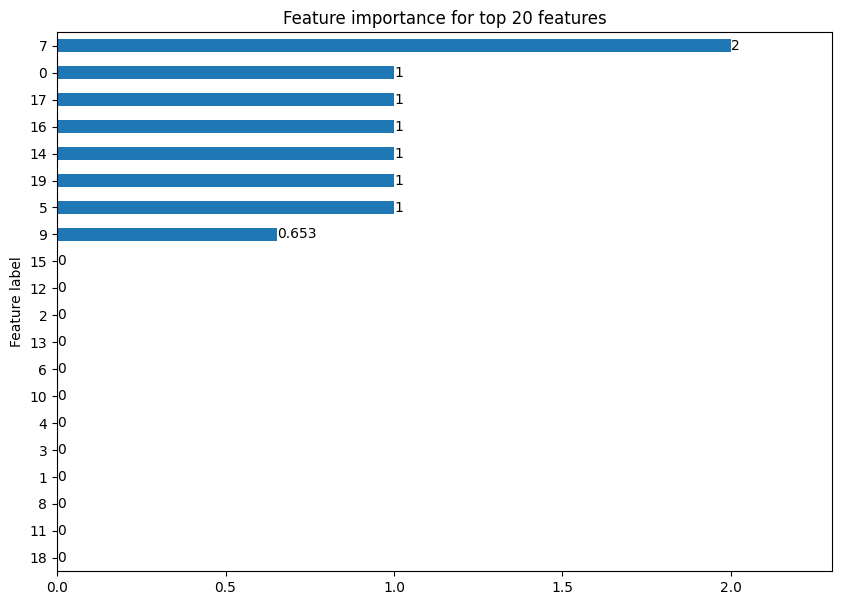

Explanation for graph aizD_mod.14.pdb_aligned: tensor([7.8644e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.3003e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


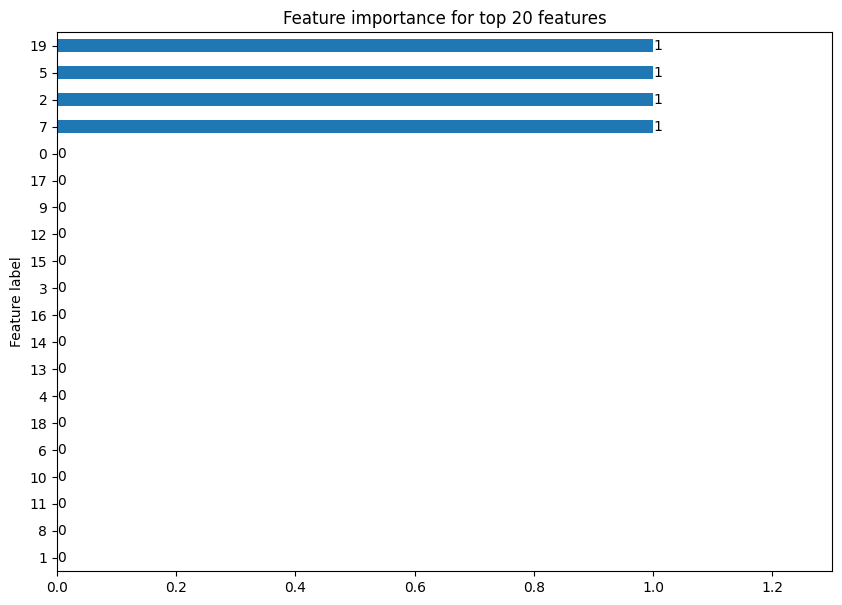

Explanation for graph fkbC_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


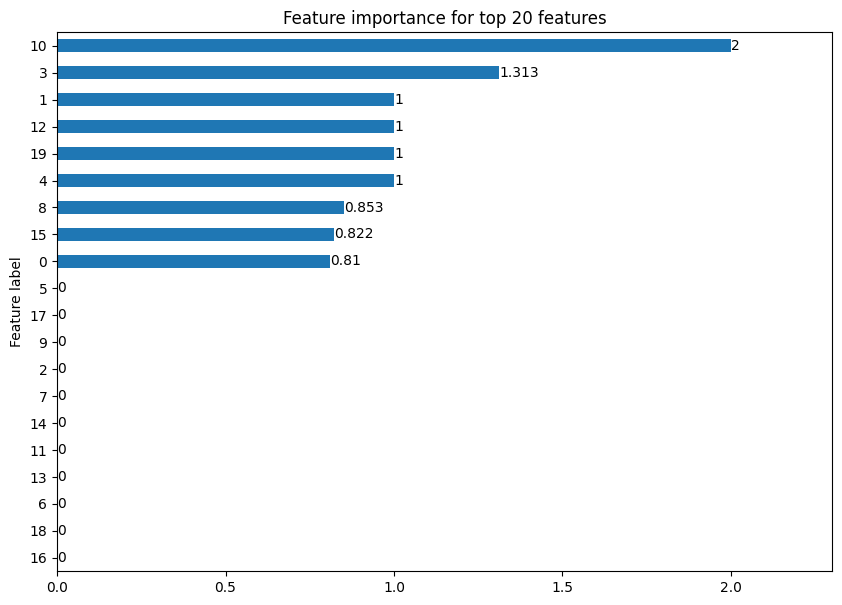

Explanation for graph herC_Mod.4.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


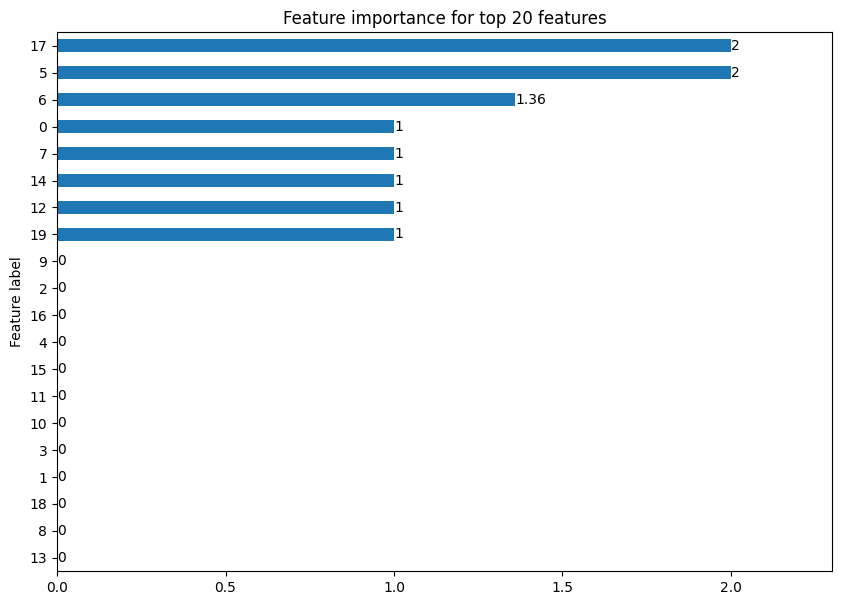

Explanation for graph TamAI_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.0365e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


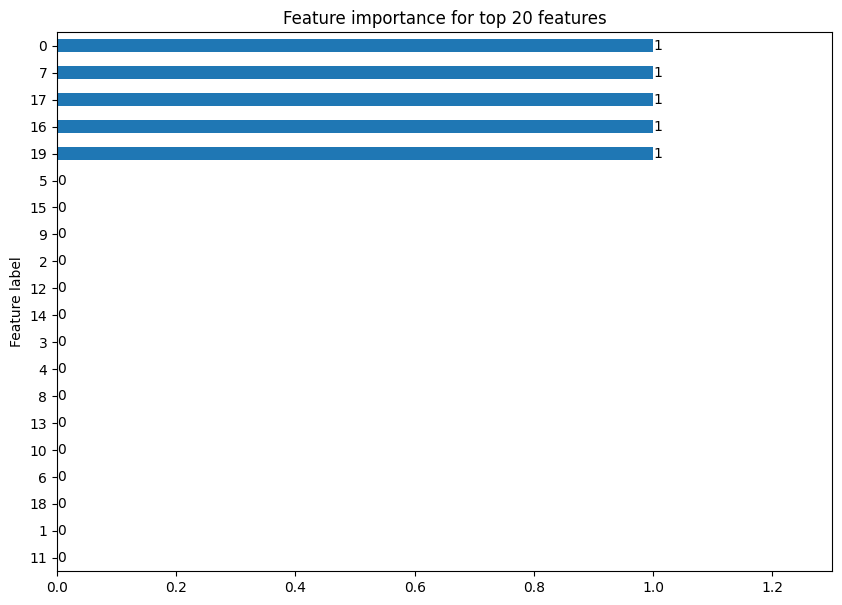

Explanation for graph nysJ_Mod.3.pdb_aligned: tensor([8.4964e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


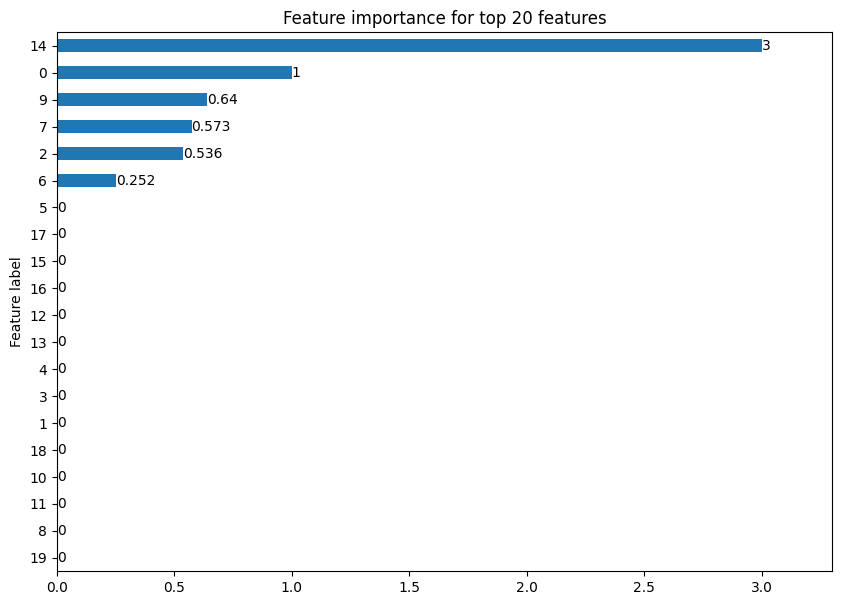

Explanation for graph rapC_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


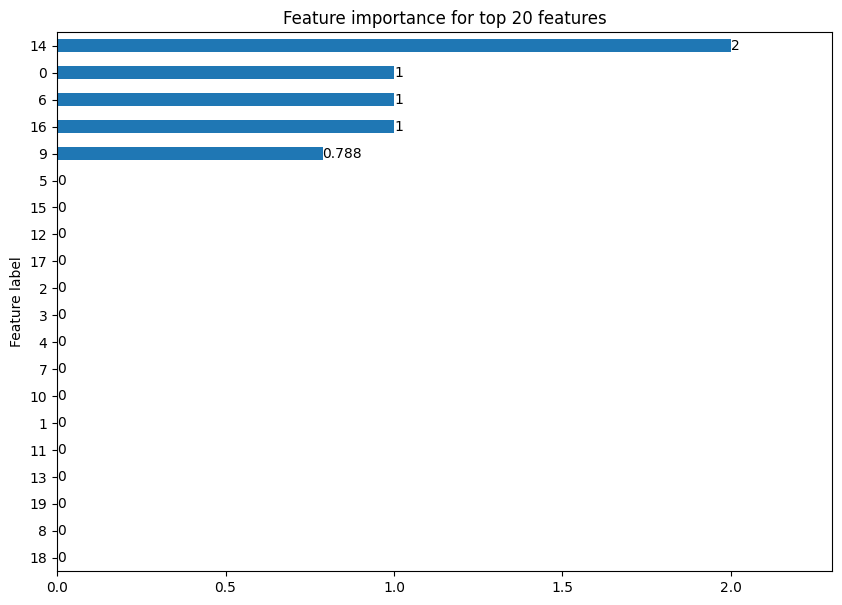

Explanation for graph cle1_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


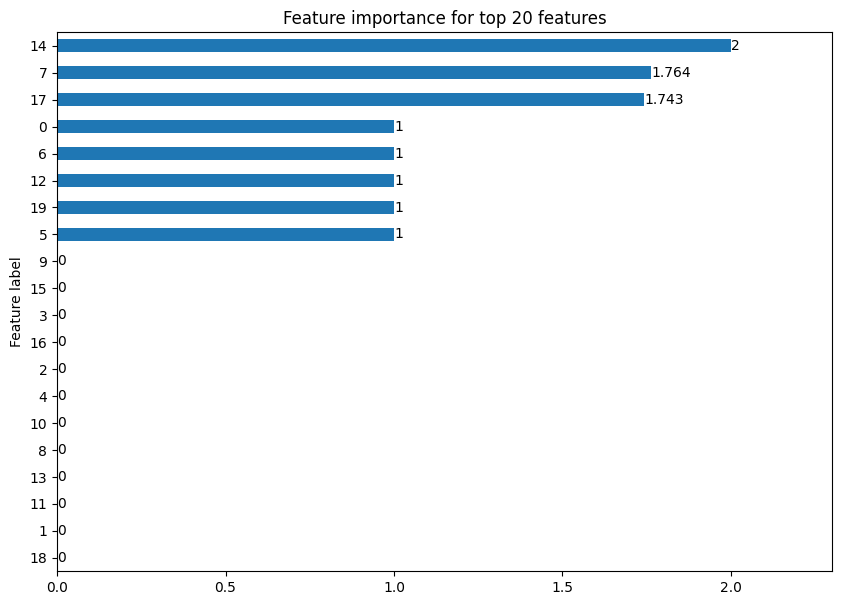

Explanation for graph stzD_Mod.2.pdb_aligned: tensor([6.9506e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[5.6700e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.4389e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


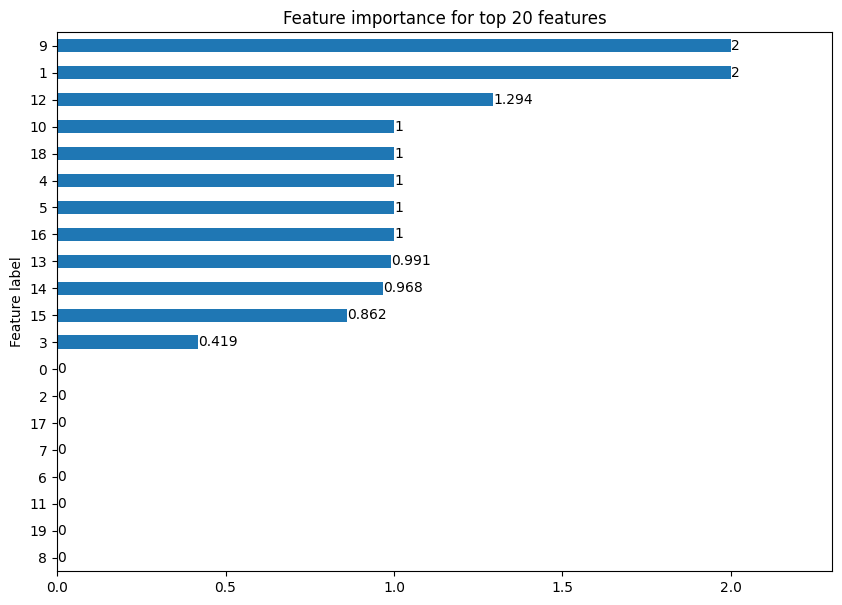

Explanation for graph ebeD_Mod.1.pdb_aligned: tensor([6.6391e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.2442e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


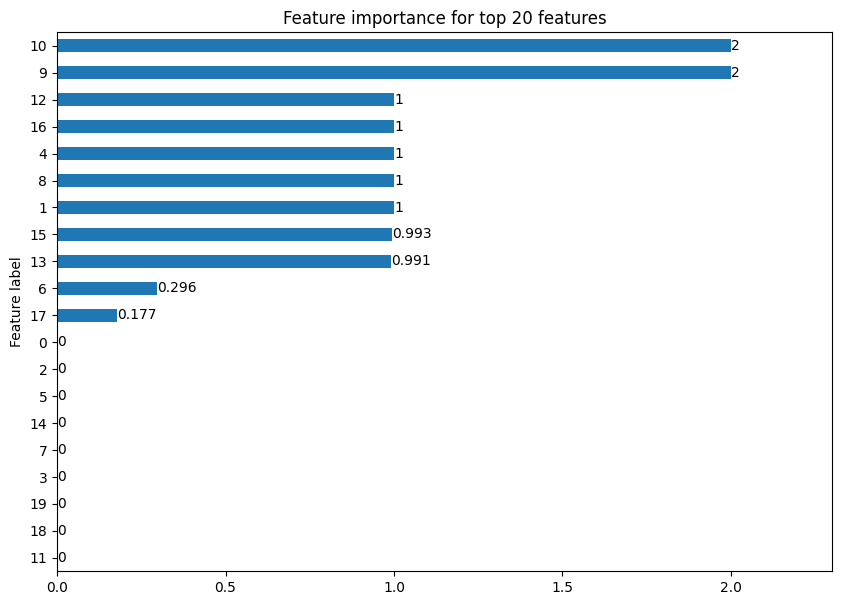

Explanation for graph arpPIII_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.0066e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


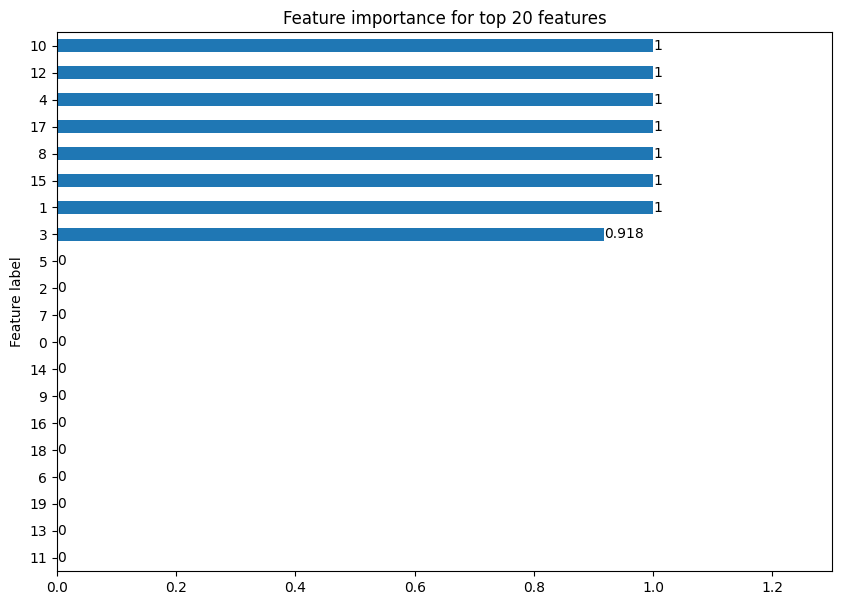

Explanation for graph nanA2_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


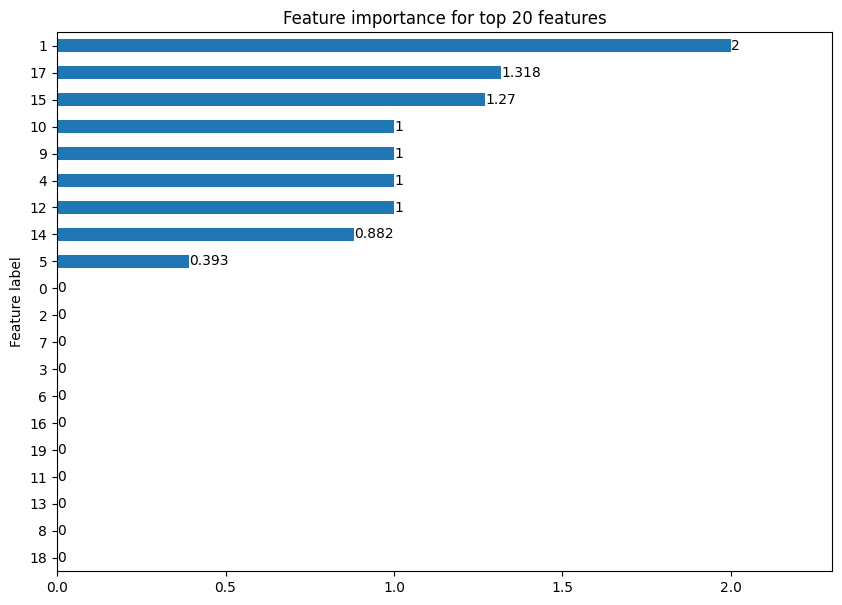

Explanation for graph ttnA_Mod.6.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


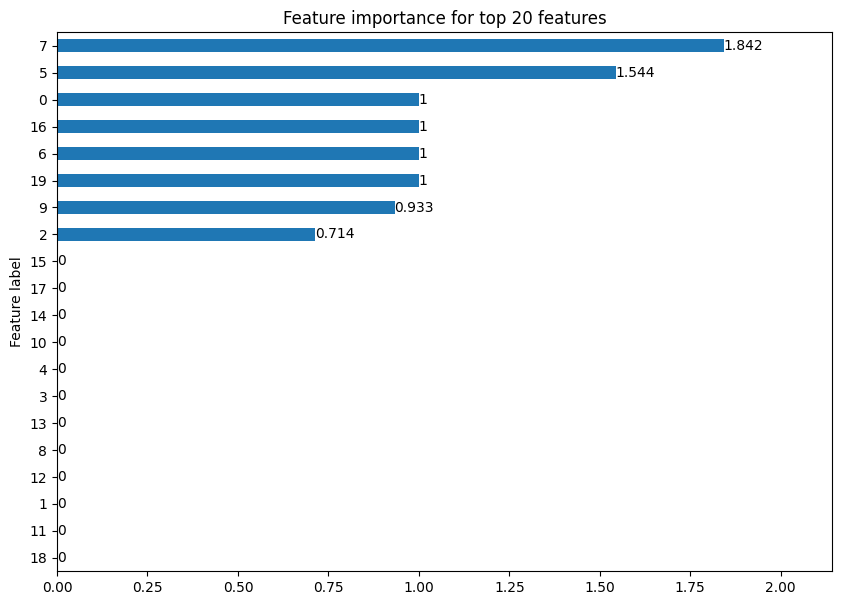

Explanation for graph sfaG_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


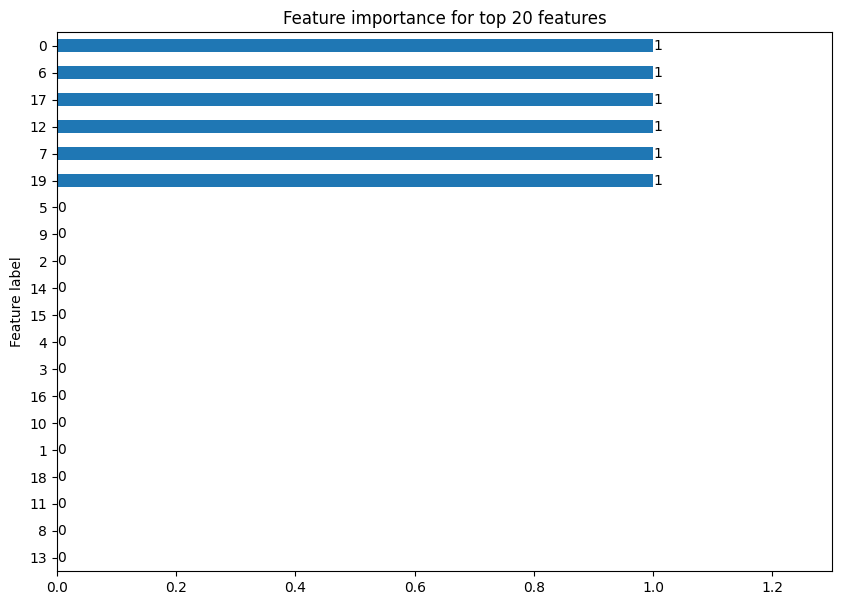

Explanation for graph fscD_Mod.6.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.8585e-10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.8614e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


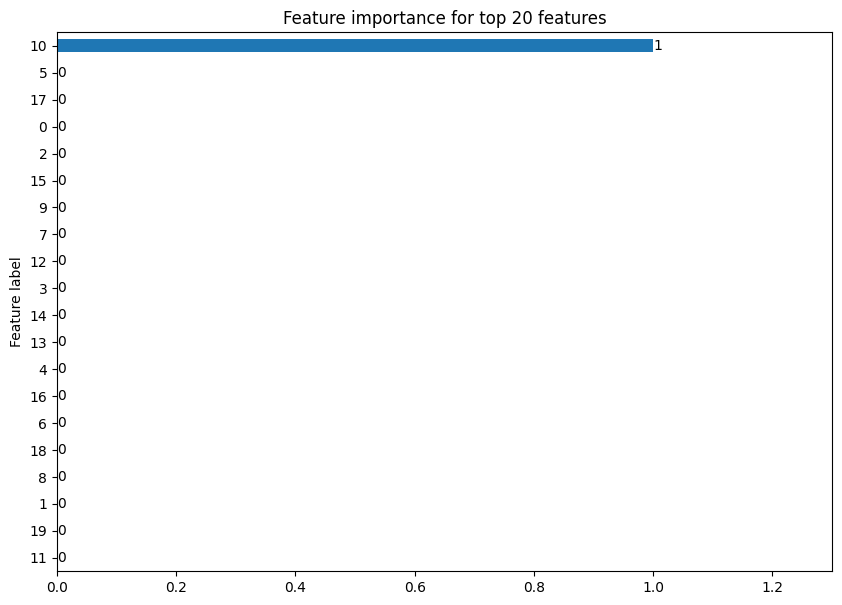

Explanation for graph merC_Mod.3.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.6704e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


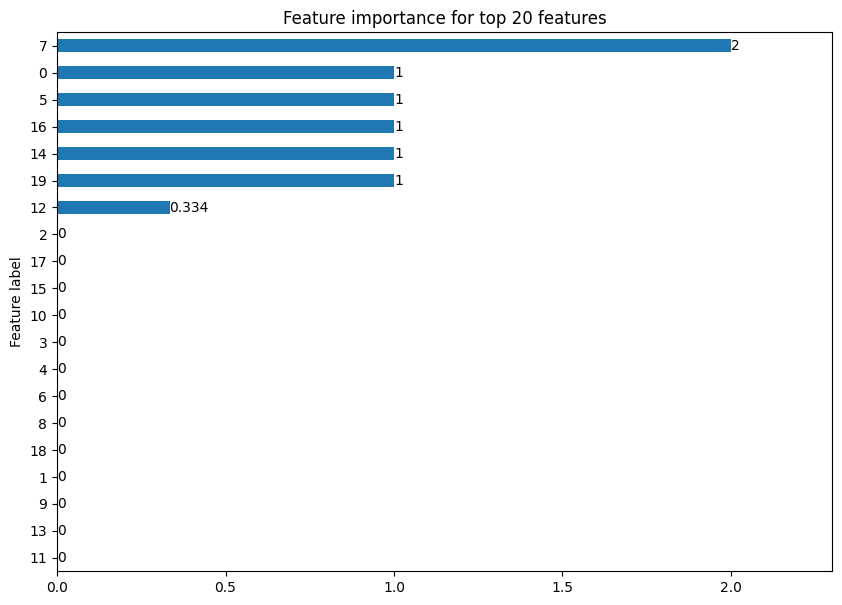

Explanation for graph cxmA_Mod.3.pdb_aligned: tensor([6.5435e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.1174e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


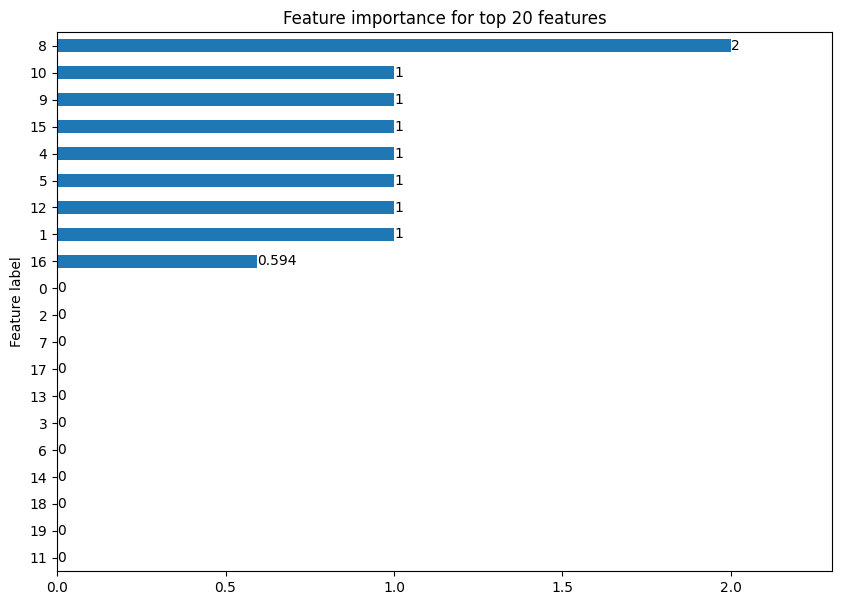

Explanation for graph fscB_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


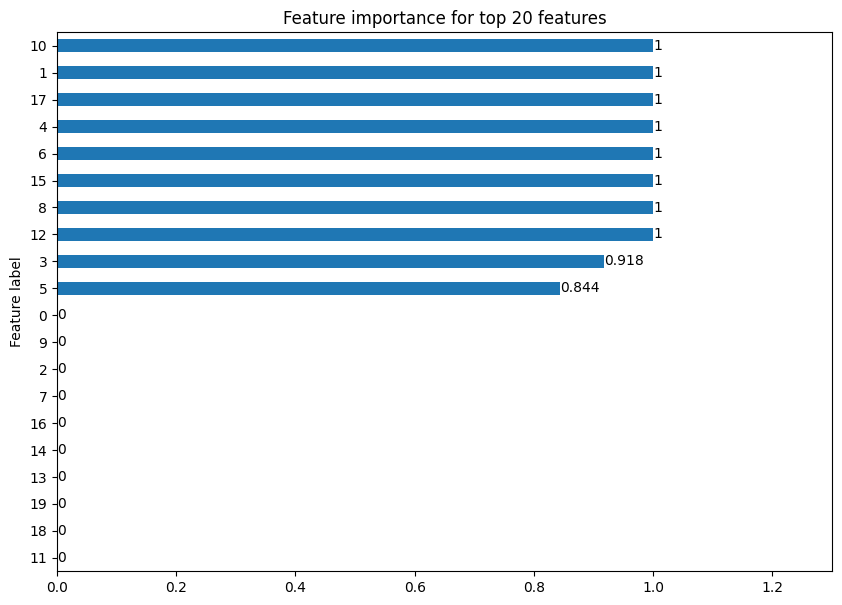

Explanation for graph SeEryAI_Mod.2.pdb_aligned: tensor([6.6048e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.5075e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


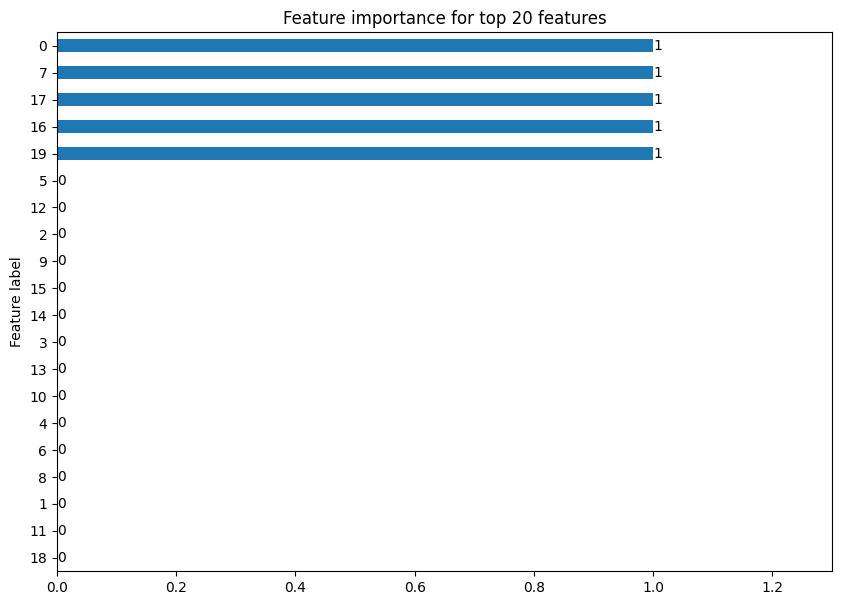

Explanation for graph cppB_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.5653e-10, 0.0000e+00,
         0.0000e+00],
        [5.5185e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


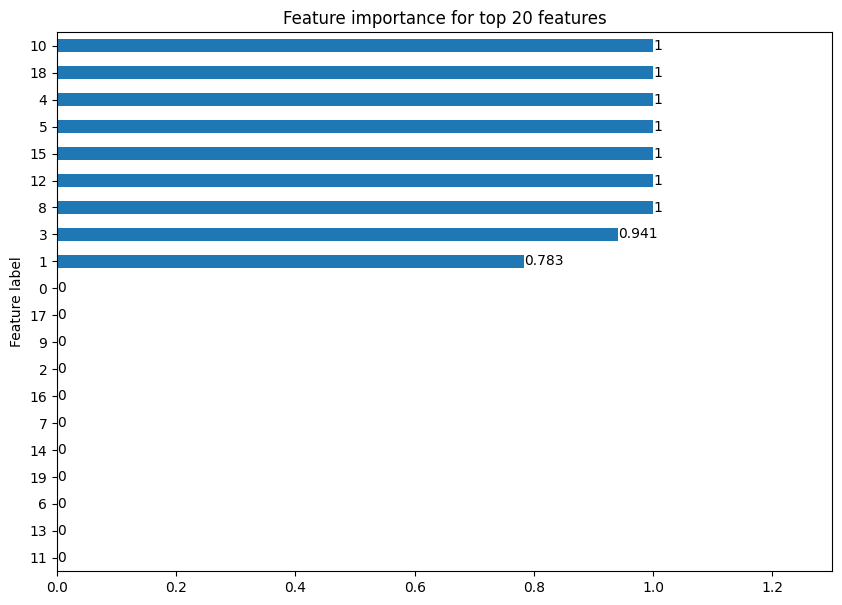

Explanation for graph cxmB_Mod.4.pdb_aligned: tensor([7.1716e-11, 0.0000e+00, 7.1858e-11,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.2197e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


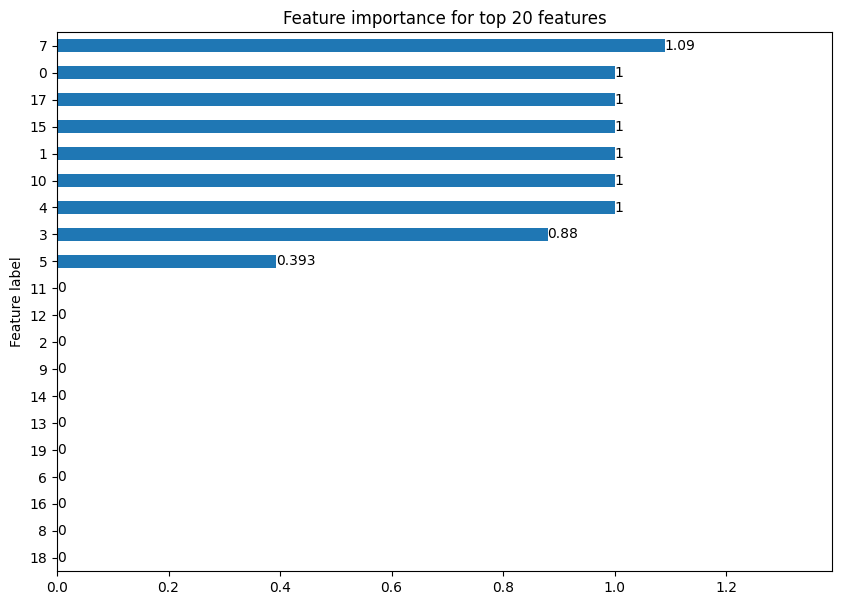

Explanation for graph hgcE_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


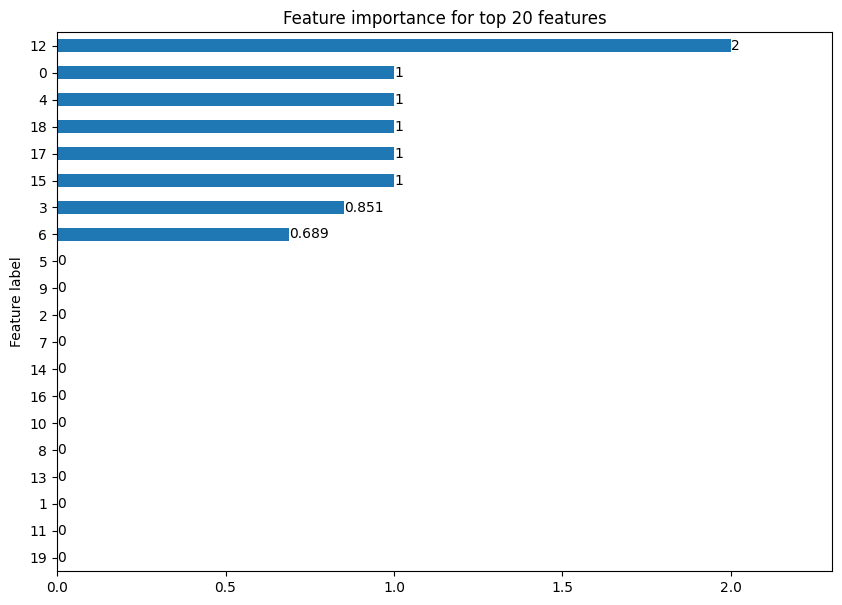

Explanation for graph AceP6_Mod.1.pdb_aligned: tensor([8.4939e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.5105e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


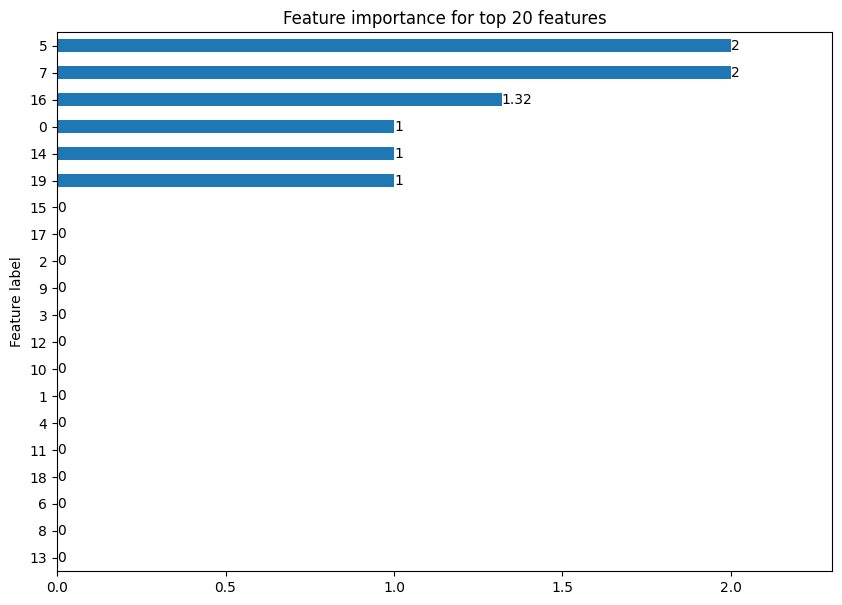

Explanation for graph azlE_Mod.11.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.2230e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


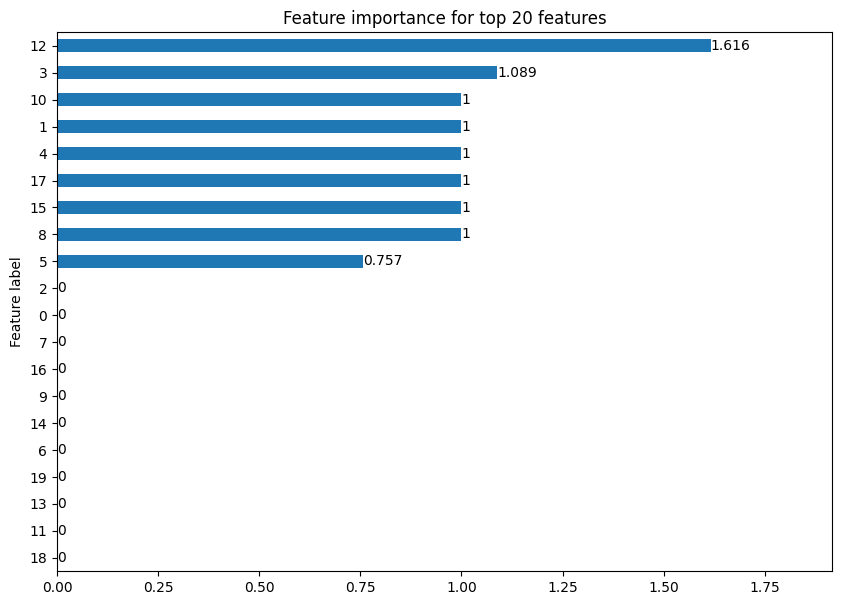

Explanation for graph gerSIII_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.4036e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


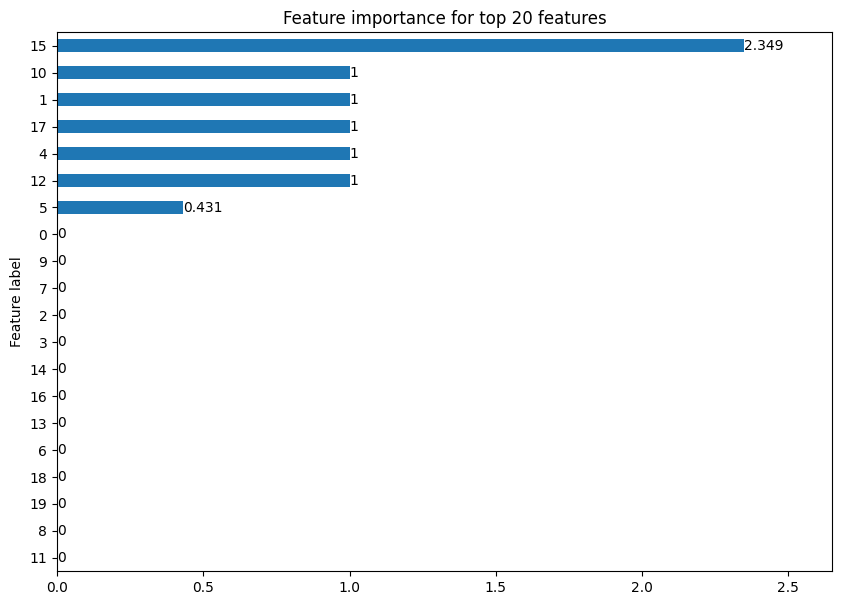

Explanation for graph simC1B_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.4172e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


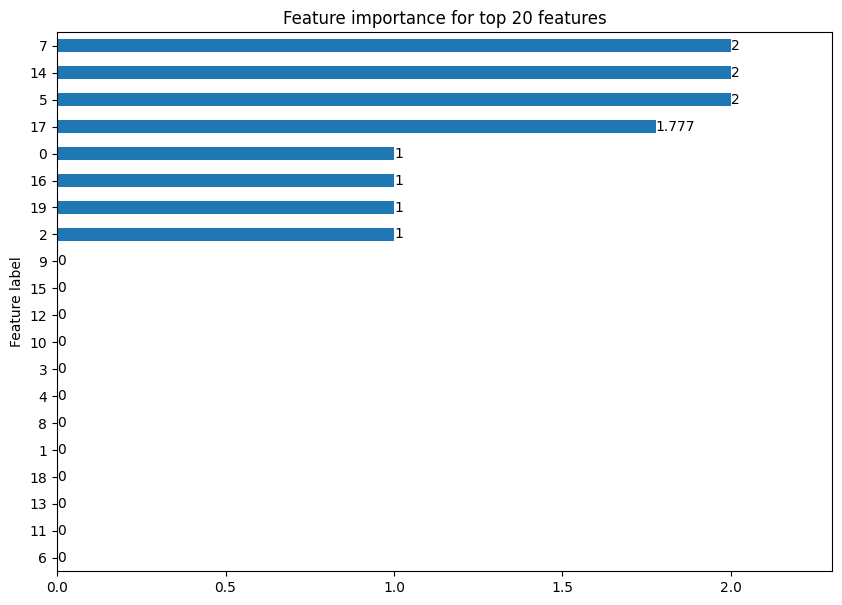

Explanation for graph fosE_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


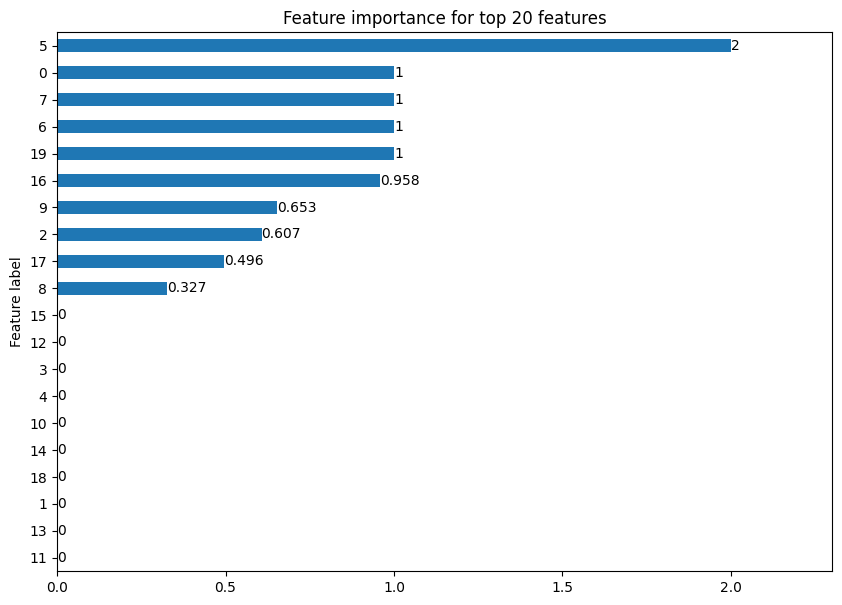

Explanation for graph conC_Mod.7.pdb_aligned: tensor([6.5988e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.3413e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.3471e-10, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


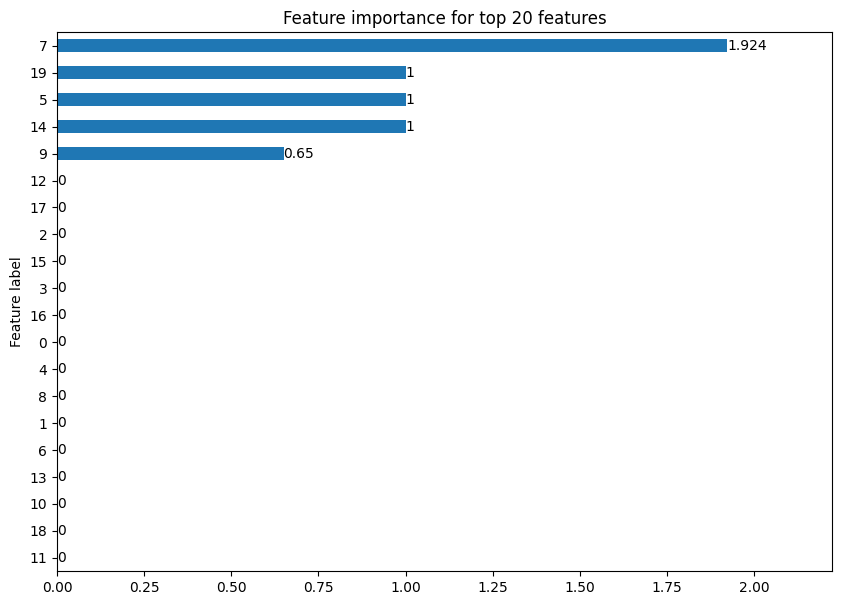

Explanation for graph SeEryAII_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.3986e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


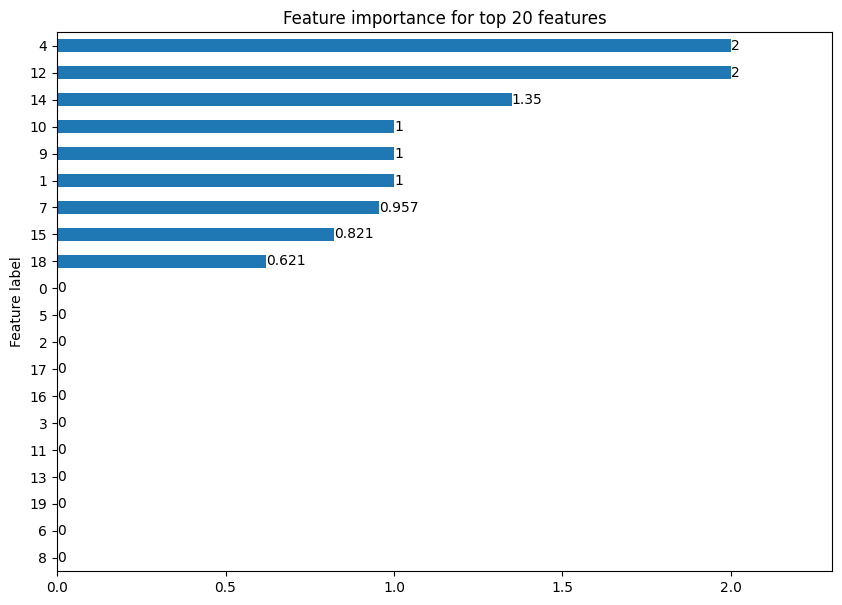

Explanation for graph norC_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


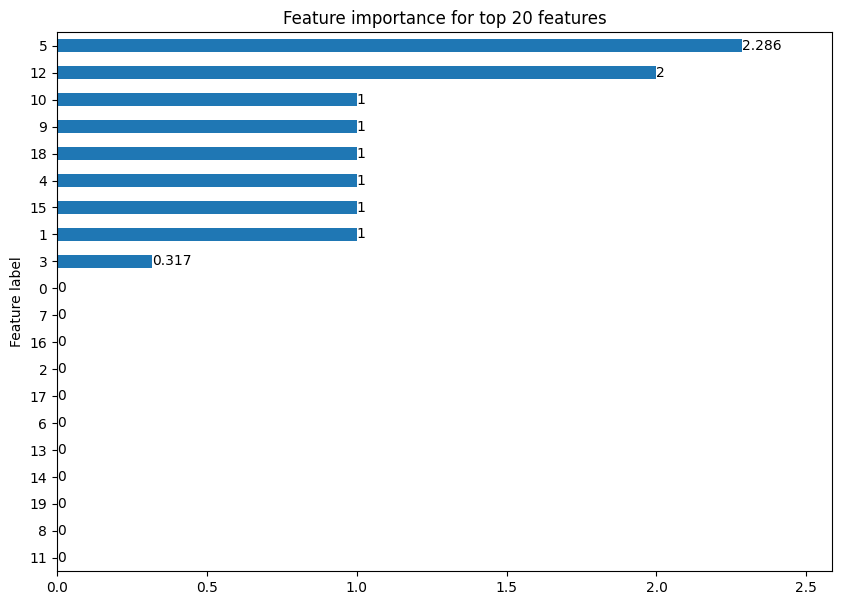

Explanation for graph gphG_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


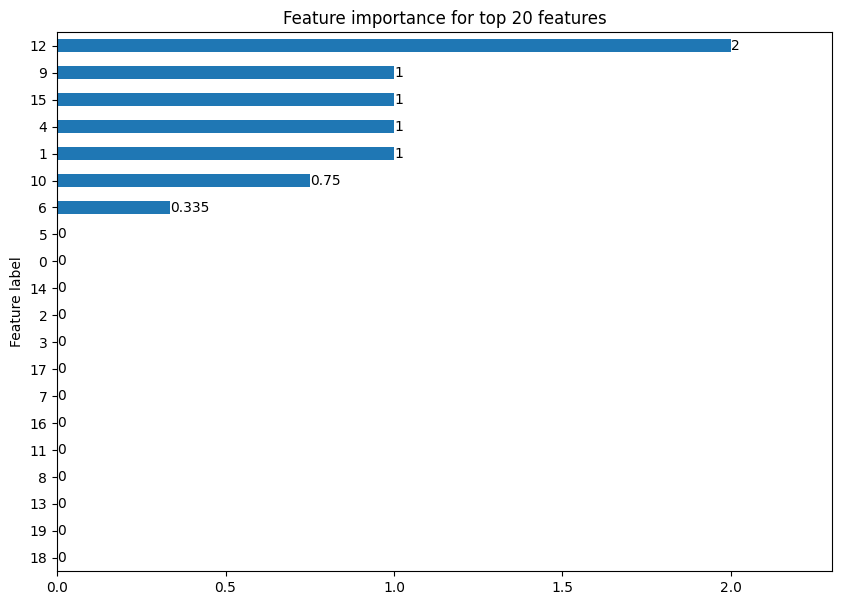

Explanation for graph SgnS1_Mod.1.pdb_aligned: tensor([6.0400e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.2665e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


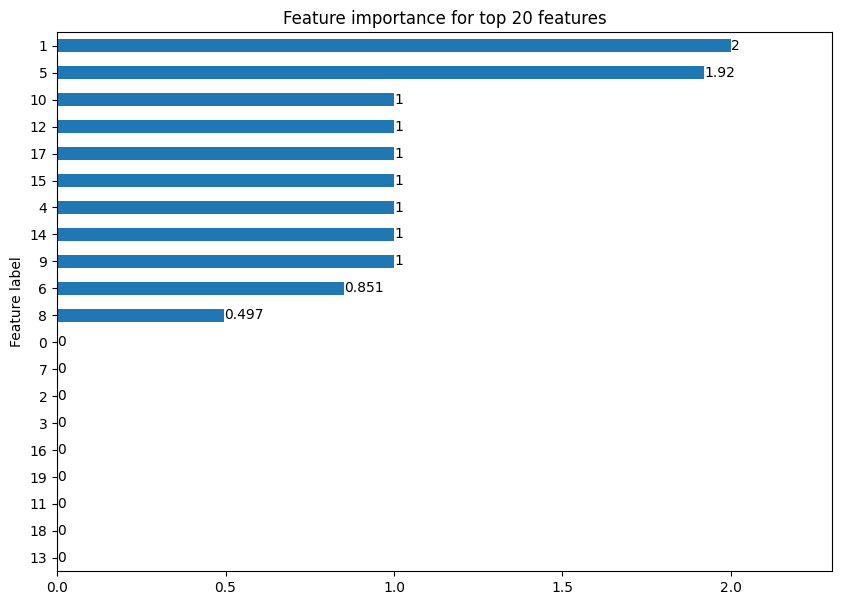

Explanation for graph npmF_Mod.12.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


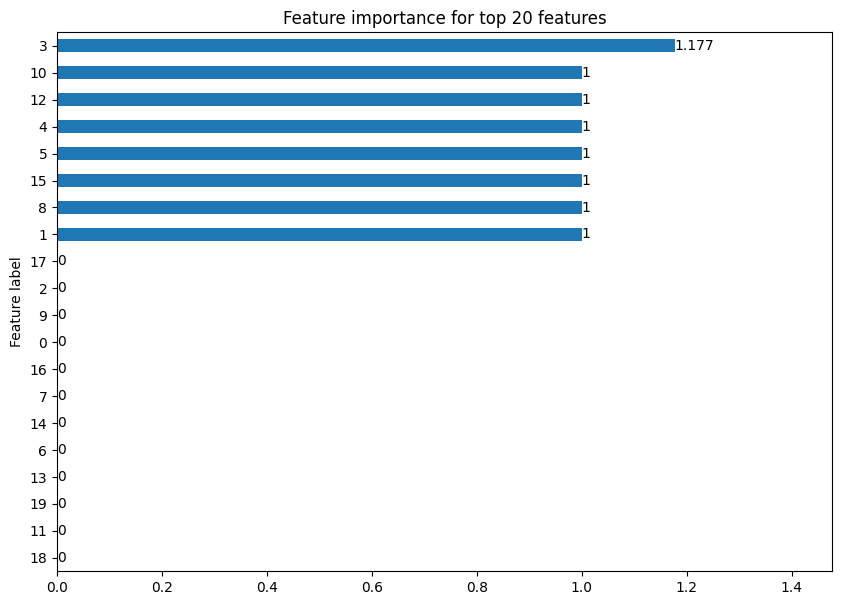

Explanation for graph cle7_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


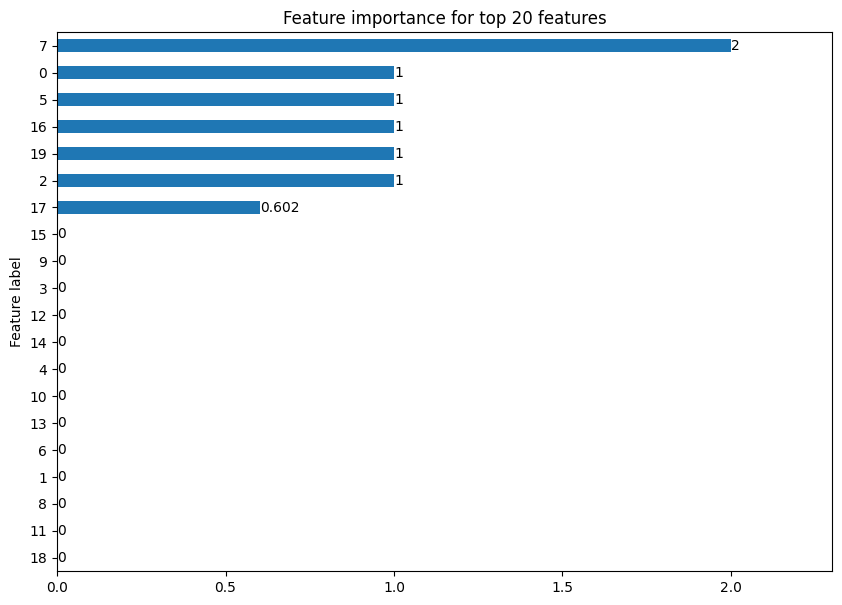

Explanation for graph cle1_Mod.5.pdb_aligned: tensor([7.8136e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.1138e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


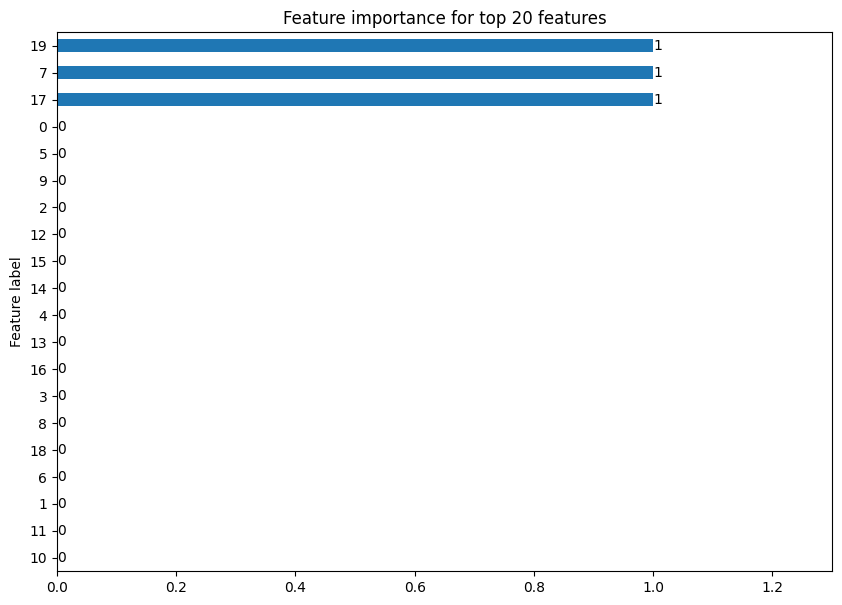

Explanation for graph cle4_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.7977e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


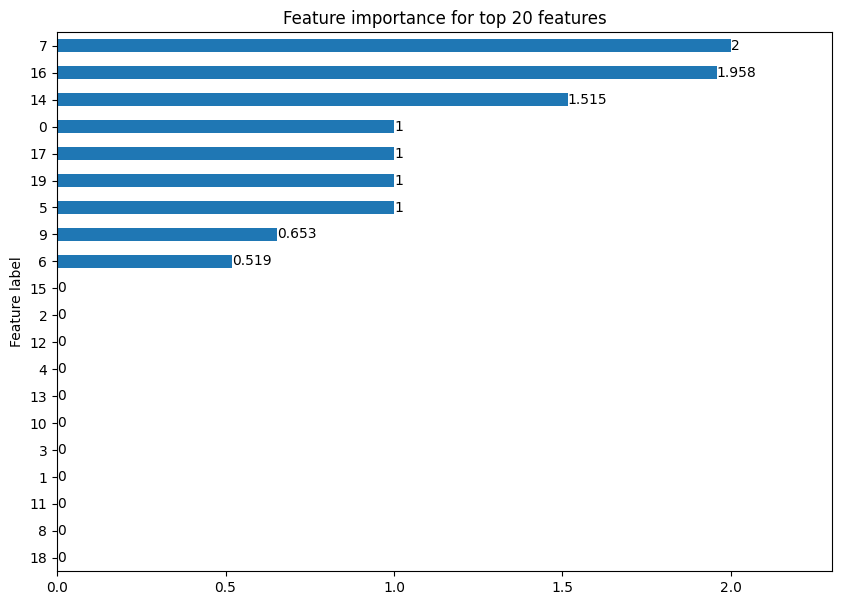

Explanation for graph aalA3_Mod.3.pdb_aligned: tensor([7.2893e-11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.8456e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


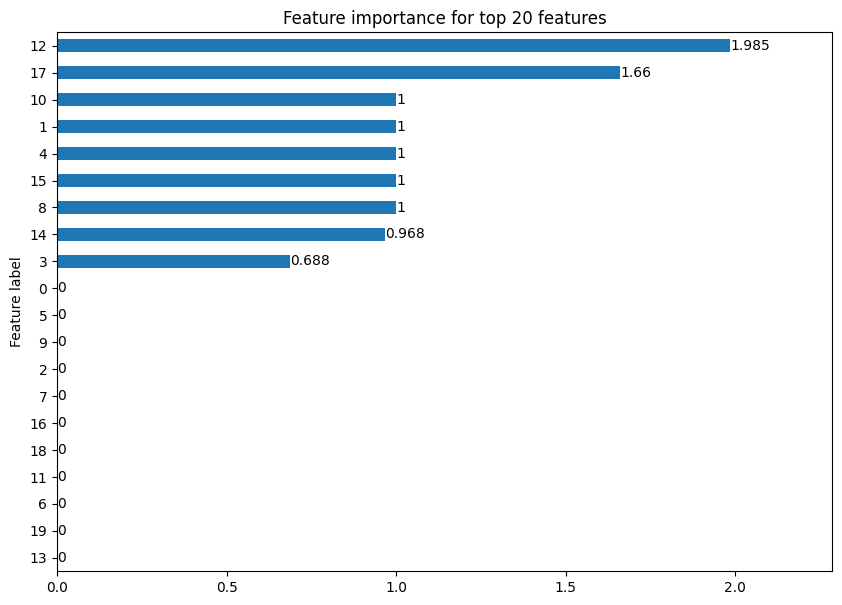

Explanation for graph cmiP8_Mod.1.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.3921e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


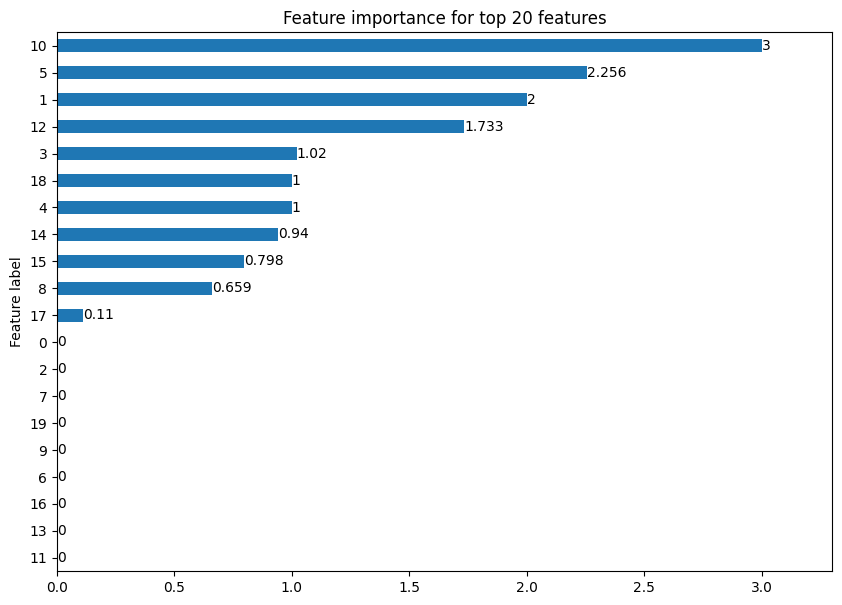

Explanation for graph nemA2_Mod.2.pdb_aligned: tensor([0., 0., 0.,  ..., 0., 0., 0.]) tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.7238e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


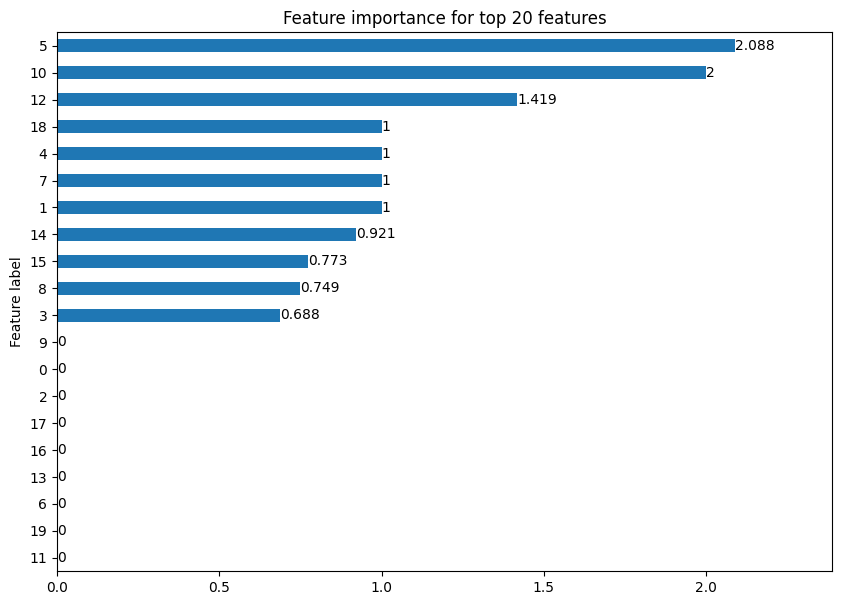

In [24]:
#### Block 5 ####
### Explainer loop ### 
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer
import torch

import numpy as np
import os
import re
from sklearn.model_selection import train_test_split
import pandas as pd
# Specify the folder where you want to save the output files
output_folder = "/home/q31032mw/Dropbox (The University of Manchester)/Max/17_ML_Project/GitHub/01 Scripts/03 Graph Networks/20250622_KRbVsNR_explainer/"

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Iterate through your loader
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100000),
    explanation_type='phenomenon', # options are model (describes the model) or phenomenon (describes why descision was made for input and input label)
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw', 
    ),
)
# Iterate through your loader
loader = val_loader
for batch in loader:
    # Print some information about the current batch
    print(f"Processing batch with {batch.num_graphs} graphs")

    # Generate explanation for each graph in the batch
    for i in range(batch.num_graphs):
        # Extract data for the i-th graph in the batch
        graph_data = batch[i]

        # Create a new Data object
        data = Data(
            edge_index=graph_data.edge_index,
            node_id=graph_data.node_id,
            coords=graph_data.coords,
            name=graph_data.name,
            num_nodes=graph_data.num_nodes,
            x=graph_data.x.view(len(graph_data.node_id), 20),
        )

        # Extract the graph-level label for the current graph
        target_values = graph_data.graph_y.tolist()
        target = torch.tensor(target_values).float()

        # Generate explanation for the node at index `10`:
        explanation = explainer(x=data.x, edge_index=data.edge_index, batch=data.batch, target=target)

        # Print or do something with the explanation for the current graph
        print(f"Explanation for graph {graph_data.name}:", explanation.edge_mask, explanation.node_mask)

        # Optionally, you can visualize the feature importance for each graph
        explanation.visualize_feature_importance(top_k=20)

        # Save the output of visualize_graph to a file in the specified folder
        graphviz_output = explanation.visualize_graph(path=os.path.join(output_folder, f"graph_output_{graph_data.name}.pdf"), backend="graphviz")
        
# Iterate through your loader
#loader = val_loader
#for batch in loader:
    # Print some information about the current batch
#    print(f"Processing batch with {batch.num_graphs} graphs")

    # Generate explanation for each graph in the batch
 #   for i in range(batch.num_graphs):
  #      # Extract data for the i-th graph in the batch
   #     graph_data = batch[i]
#
 #       # Create a new Data object
  #      data = Data(
   #         edge_index=graph_data.edge_index,
    #        node_id=graph_data.node_id,
     #       coords=graph_data.coords,
      #      name=graph_data.name,
#            num_nodes=graph_data.num_nodes,
 #           x=graph_data.x.view(len(graph_data.node_id), 20),
  #      )
#
 #       # Extract the graph-level label for the current graph
  #      target_values = graph_data.graph_y.tolist()
   #     target = torch.tensor(target_values).float()
#
 ##       # Generate explanation for the node at index `10`:
   #     explanation = explainer(x=data.x, edge_index=data.edge_index, batch=data.batch, target=target)
#
 #       # Print or do something with the explanation for the current graph
  #      print(f"Explanation for graph {graph_data.name}:", explanation.edge_mask, explanation.node_mask)
#
 #       # Optionally, you can visualize the feature importance for each graph
 #       explanation.visualize_feature_importance(top_k=20)
#
 #       # Save the output of visualize_graph to a file in the specified folder
  #      graphviz_output = explanation.visualize_graph(path=os.path.join(output_folder, f"graph_output_{graph_data.name}.pdf"), backend="graphviz")
